In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

In [2]:
%%time
init_shape = (10, 10, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.02)
assert check_coo_tensor(coo)!= "Bad"

max_iter = 12
rank = 20

a, b, c, _, _ = wrcp.wrcp_als3(
    coo,
    vals,
    init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter
)
rerr = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(rerr)

1.0
CPU times: user 8.4 s, sys: 240 ms, total: 8.64 s
Wall time: 8.35 s


In [3]:
inds_list = pickle.load(open('../wikidata_tensors/fb_list.pcl', 'rb'))
ind_to_entity = pickle.load(open('../wikidata_tensors/fb_idx2ent.pcl', 'rb'))
ind_to_rel = pickle.load(open('../wikidata_tensors/fb_idx2rel.pcl', 'rb'))

In [4]:
values = [1] * len(inds_list)
values = np.array(values, dtype=np.float64)

coords = np.array(inds_list, dtype=np.int32)
nnz = len(inds_list)
data_shape = (14242, 1182, 14242)

In [5]:
max_iter = 10
rank = 10
l2 = 1e-4 

In [6]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords,
    values,
    data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter
)

iterations over
CPU times: user 7min 52s, sys: 1.2 s, total: 7min 53s
Wall time: 7min 52s


In [7]:
rerr = sqrt_err_relative(
    coords,
    values,
    data_shape,
    a,
    b,
    c,
)
print(f"Relative error = {rerr}")

Relative error = 0.06867203132252285


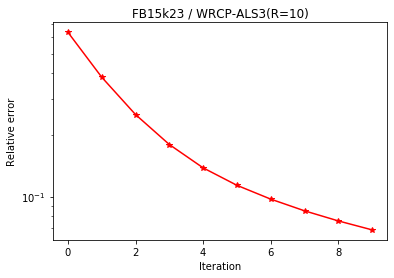

In [10]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15k23 / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err_arr[:it], 'r-*')

## Let's look at Tucker TD:

In [4]:
import polara.lib.hosvd as hosvd

In [39]:
%%time
core_shape = (50, 50, 50)
p, q, r, g = hosvd.tucker_als(
    idx=coords,
    val=values,
    shape=data_shape,
    core_shape=core_shape,
    iters=25,
    growth_tol=0.01,
    batch_run=False,
    seed=None,
)

Step 1 of 25
growth of the core: 1.000000
Step 2 of 25
growth of the core: 0.102266
Step 3 of 25
growth of the core: 0.005515
Core is no longer growing. Norm of the core: 329.956001
Done
CPU times: user 1min 8s, sys: 1.52 s, total: 1min 9s
Wall time: 41.3 s


### Write function to calculate the error:

In [25]:
from numba import jit

In [35]:
@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

In [36]:
@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [40]:
rerr = sqrt_err_relative_tucker(
    coords,
    values,
    data_shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 0.8685002486828957
